# Importação dos dados

In [84]:
from ucimlrepo import fetch_ucirepo 
  
cardiotocography = fetch_ucirepo(id=193) 
  
X = cardiotocography.data.features 
y = cardiotocography.data.targets 
  
print(cardiotocography.metadata) 
print(cardiotocography.variables) 


{'uci_id': 193, 'name': 'Cardiotocography', 'repository_url': 'https://archive.ics.uci.edu/dataset/193/cardiotocography', 'data_url': 'https://archive.ics.uci.edu/static/public/193/data.csv', 'abstract': 'The dataset consists of measurements of fetal heart rate (FHR) and uterine contraction (UC) features on cardiotocograms classified by expert obstetricians.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 2126, 'num_features': 21, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['CLASS', 'NSP'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2000, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C51S4N', 'creators': ['D. Campos', 'J. Bernardes'], 'intro_paper': None, 'additional_info': {'summary': '2126 fetal cardiotocograms (CTGs) were automatically processed and the respective diagnostic features measured. The CTGs were also classified

In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.concat([X, y], axis=1)

df.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
0,120,0.000,0.0,0.000,0.000,0.0,0.0,73,0.5,43,...,126,2,0,120,137,121,73,1,9,2
1,132,0.006,0.0,0.006,0.003,0.0,0.0,17,2.1,0,...,198,6,1,141,136,140,12,0,6,1
2,133,0.003,0.0,0.008,0.003,0.0,0.0,16,2.1,0,...,198,5,1,141,135,138,13,0,6,1
3,134,0.003,0.0,0.008,0.003,0.0,0.0,16,2.4,0,...,170,11,0,137,134,137,13,1,6,1
4,132,0.007,0.0,0.008,0.000,0.0,0.0,16,2.4,0,...,170,9,0,137,136,138,11,1,2,1


In [86]:
df_pre_proc = pd.read_csv('CTG_pre_processado.csv')
df_pre_proc.head()


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,0.259259,0.000000,0.0,0.000000,0.0,0.0,0.0,0.813333,0.044118,0.472527,...,0.110092,0.034483,0.111111,0.0,0.472441,0.587156,0.403670,0.271375,1.0,2
1,0.481481,0.315789,0.0,0.400000,0.2,0.0,0.0,0.066667,0.279412,0.000000,...,0.165138,0.655172,0.333333,0.1,0.637795,0.577982,0.577982,0.044610,0.5,1
2,0.500000,0.157895,0.0,0.533333,0.2,0.0,0.0,0.053333,0.279412,0.000000,...,0.165138,0.655172,0.277778,0.1,0.637795,0.568807,0.559633,0.048327,0.5,1
3,0.518519,0.157895,0.0,0.533333,0.2,0.0,0.0,0.053333,0.323529,0.000000,...,0.027523,0.413793,0.611111,0.0,0.606299,0.559633,0.550459,0.048327,1.0,1
4,0.481481,0.368421,0.0,0.533333,0.0,0.0,0.0,0.053333,0.323529,0.000000,...,0.027523,0.413793,0.500000,0.0,0.606299,0.577982,0.559633,0.040892,1.0,1


# Separação dos conjuntos

In [87]:
X = df.drop(columns=['NSP', 'CLASS'])
y = df['NSP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
X_train = X_train.astype(float)
X_test = X_test.astype(float)

In [88]:
X_pre_proc = df_pre_proc.drop(columns=['NSP'])
y_pre_proc = df_pre_proc['NSP']

X_train_pre_proc, X_test_pre_proc, y_train_pre_proc, y_test_pre_proc = train_test_split(X, y, test_size=0.4, random_state=0)
X_train_pre_proc = X_train_pre_proc.astype(float)
X_test_pre_proc = X_test_pre_proc.astype(float)

# Definição de funções e parâmetros

In [89]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, accuracy_score, confusion_matrix, fbeta_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_best_model(grid_search, X_test, y_test):
    # Melhor modelo do grid search
    best_model = grid_search.best_estimator_

    # Previsões do modelo
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)

    test_metrics = {}
    
    # Cálculo das métricas
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    fbeta = fbeta_score(y_test, y_pred, average='weighted', beta=2)

    # Criação dos dummies pois a curva roc usa dados binários
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    roc_auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovo', average='weighted')
    
    # Exibindo retornos
    test_metrics['F1'] = f1
    test_metrics['ACURACIA'] = accuracy
    test_metrics['Fbeta'] = fbeta
    test_metrics['ROC_AUC'] = roc_auc

    print(f"F1 no conjunto de teste: {f1}")
    print(f"ACURACIA no conjunto de teste: {accuracy}")
    print(f"Fbeta no conjunto de teste: {fbeta}")
    print(f"Área sob a curva ROC no conjunto de teste: {roc_auc}")

    print('Matriz de confusão:')
    conf_matrix = confusion_matrix(y_test, y_pred, labels=[1, 2, 3])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=["1", "2", "3"], yticklabels=["1", "2", "3"])
    plt.title('Matriz de Confusão')
    plt.tight_layout()
    plt.show()
    
    print('Area sob a curva ROC por classe:')
    
    plt.figure(figsize=(8, 6))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, marker='.', label=f'NSP {i + 1}')

    plt.xlabel('Falso positivo')
    plt.ylabel('Positivos')
    plt.title('Curva ROC para cada NSP')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    return test_metrics

In [90]:
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# F-beta
fbeta_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

scores = {'ROC_AUC': 'roc_auc_ovo_weighted', 
          'Fbeta': fbeta_scorer, 
          'F1': 'f1_weighted', 
          'ACURACIA': 'accuracy'}


experiment_mapping = {
    'KNN': 'KNN',
    'DecisionTree': 'Decision Tree',
    'MLP': 'MLP',
    'NaiveBayes': 'Naive Bayes'
}

classifiers = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'param_grid': {
            'n_neighbors': [3, 5, 8, 10, 12, 15, 18, 20, 21, 22, 25],
            'weights': ['uniform', 'distance']
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 10, 20, 30, 40, 50]
        }
    },
    'MLP': {
        'model': MLPClassifier(max_iter=1000),
        'param_grid': {
            'hidden_layer_sizes': [(50,50), (100,)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive'],
        }
    },
    'NaiveBayes': {
        'model': GaussianNB(),
        'param_grid': {
            'var_smoothing': [1e-09, 1e-08, 1e-07]
        }
    }
}

# Modelos

Para cada modelos vamos gerar o melhor conjunto de hiperparâmetros considerando cada métrica.

## Dados sem pré processamento

2024/08/11 13:52:01 INFO mlflow.tracking.fluent: Experiment with name 'KNN' does not exist. Creating a new experiment.


=== Treinando KNN ===
Fitting 10 folds for each of 22 candidates, totalling 220 fits
Melhor ROC_AUC no conjunto de treinamento: 0.9446169526079826
F1 no conjunto de teste: 0.8909292689311512
ACURACIA no conjunto de teste: 0.8977673325499412
Fbeta no conjunto de teste: 0.8943163619590785
Área sob a curva ROC no conjunto de teste: 0.950751904622578
Matriz de confusão:


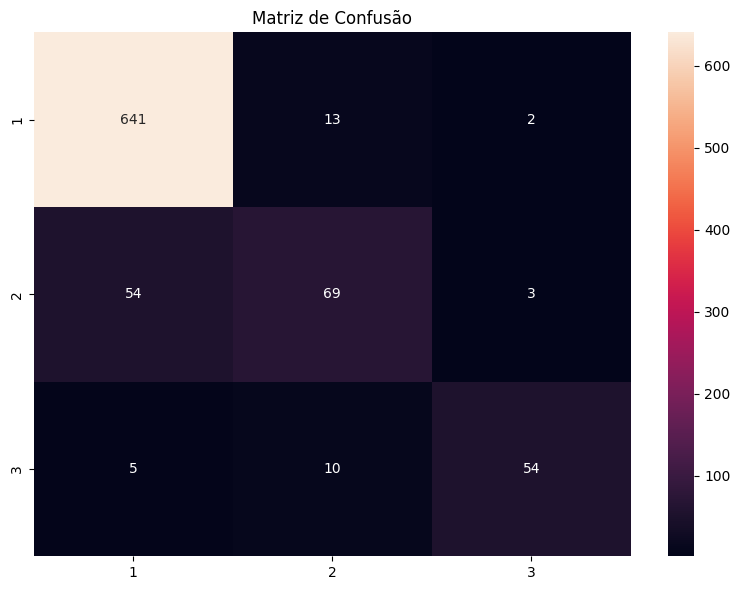

Area sob a curva ROC por classe:


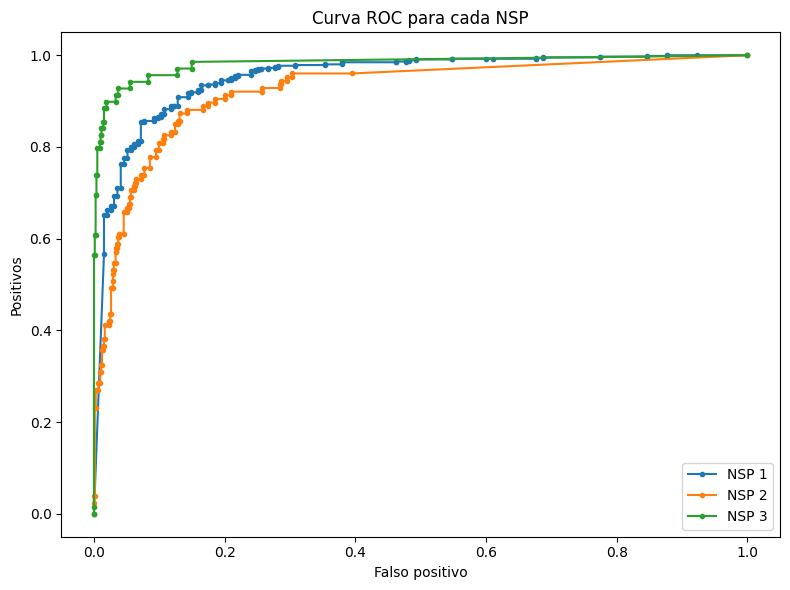

Fitting 10 folds for each of 22 candidates, totalling 220 fits
Melhor Fbeta no conjunto de treinamento: 0.8985546946178818
F1 no conjunto de teste: 0.9068174584536597
ACURACIA no conjunto de teste: 0.9095182138660399
Fbeta no conjunto de teste: 0.9082575141149944
Área sob a curva ROC no conjunto de teste: 0.9174662951661919
Matriz de confusão:


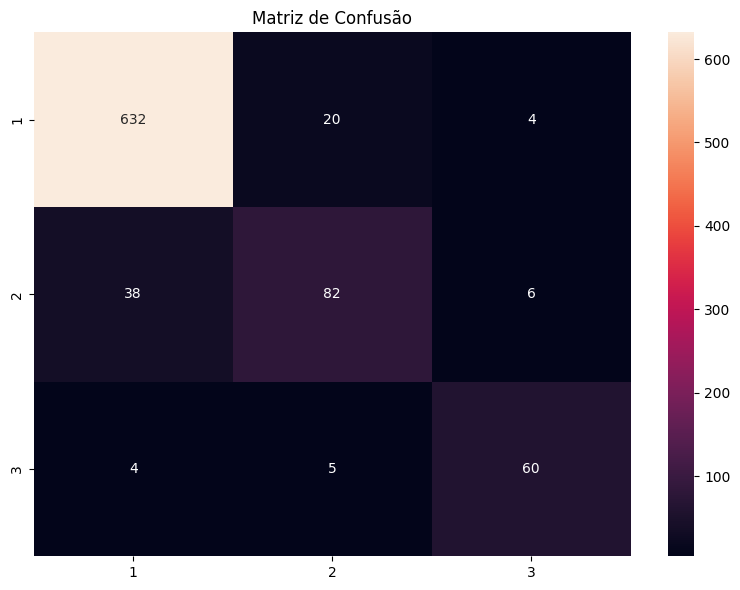

Area sob a curva ROC por classe:


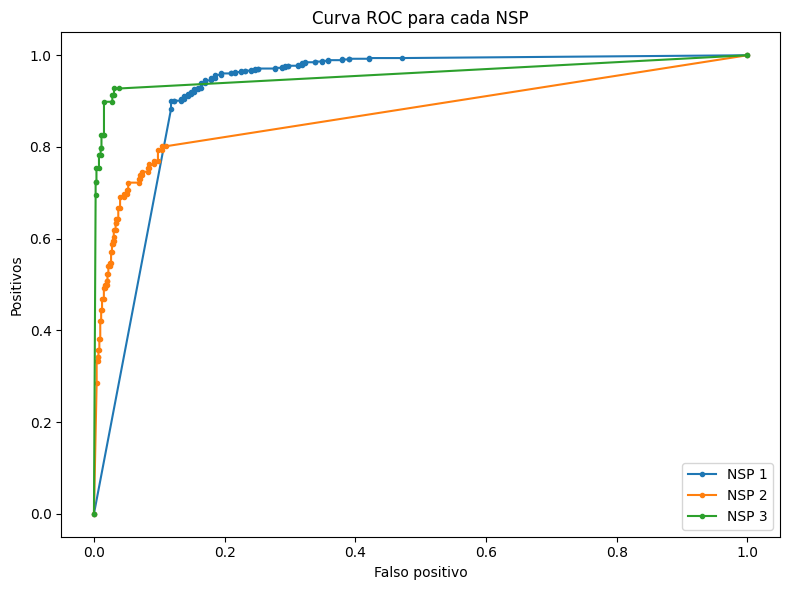

Fitting 10 folds for each of 22 candidates, totalling 220 fits
Melhor F1 no conjunto de treinamento: 0.8968036496727381
F1 no conjunto de teste: 0.9068174584536597
ACURACIA no conjunto de teste: 0.9095182138660399
Fbeta no conjunto de teste: 0.9082575141149944
Área sob a curva ROC no conjunto de teste: 0.9174662951661919
Matriz de confusão:


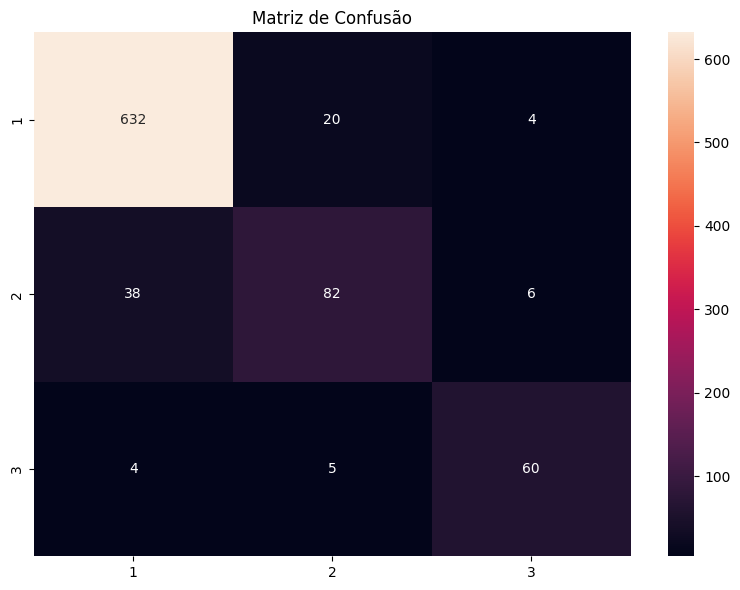

Area sob a curva ROC por classe:


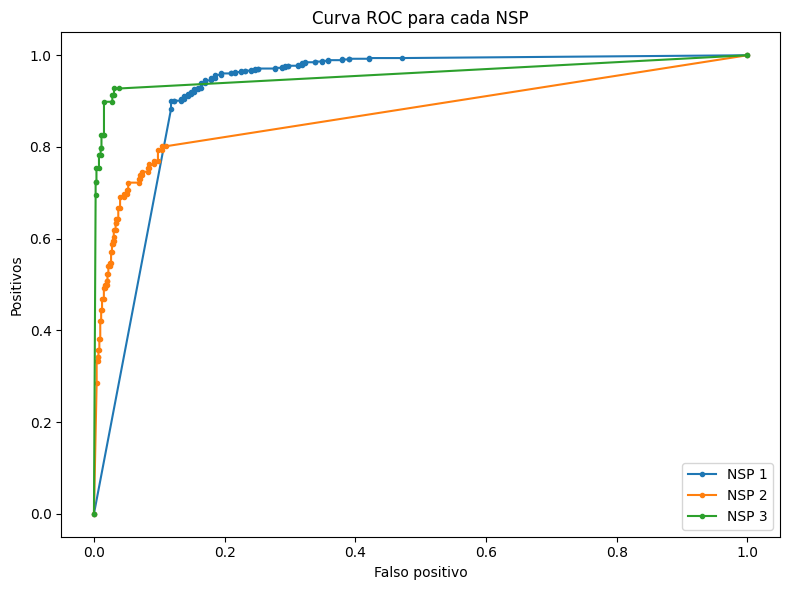

Fitting 10 folds for each of 22 candidates, totalling 220 fits
Melhor ACURACIA no conjunto de treinamento: 0.9004183070866141
F1 no conjunto de teste: 0.9068174584536597
ACURACIA no conjunto de teste: 0.9095182138660399
Fbeta no conjunto de teste: 0.9082575141149944
Área sob a curva ROC no conjunto de teste: 0.9174662951661919
Matriz de confusão:


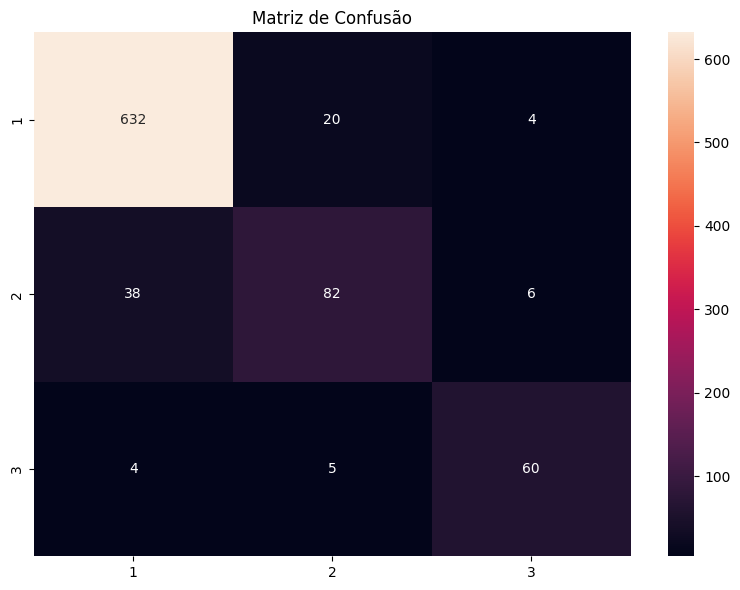

Area sob a curva ROC por classe:


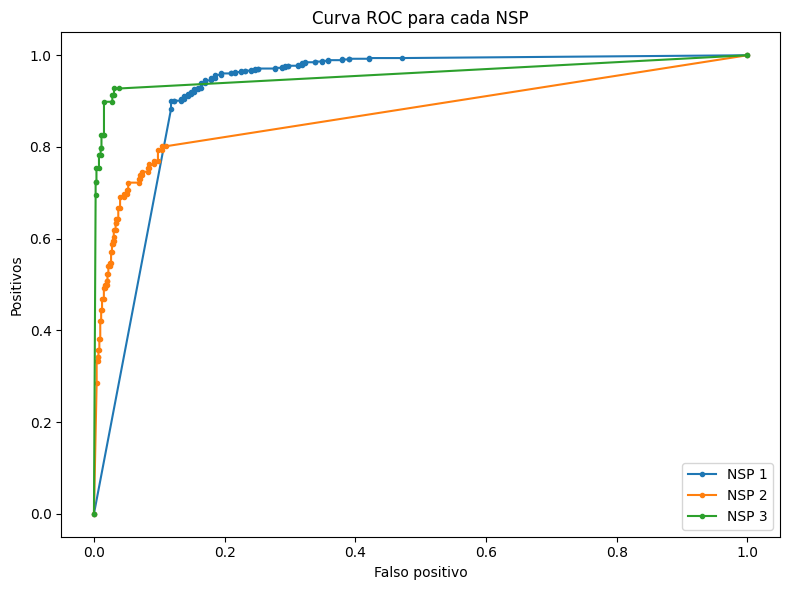

2024/08/11 13:52:26 INFO mlflow.tracking.fluent: Experiment with name 'Decision Tree' does not exist. Creating a new experiment.


=== Treinando DecisionTree ===
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Melhor ROC_AUC no conjunto de treinamento: 0.890073643602428
F1 no conjunto de teste: 0.9228091654385391
ACURACIA no conjunto de teste: 0.9247943595769683
Fbeta no conjunto de teste: 0.9238475402850127
Área sob a curva ROC no conjunto de teste: 0.8924500395026895
Matriz de confusão:


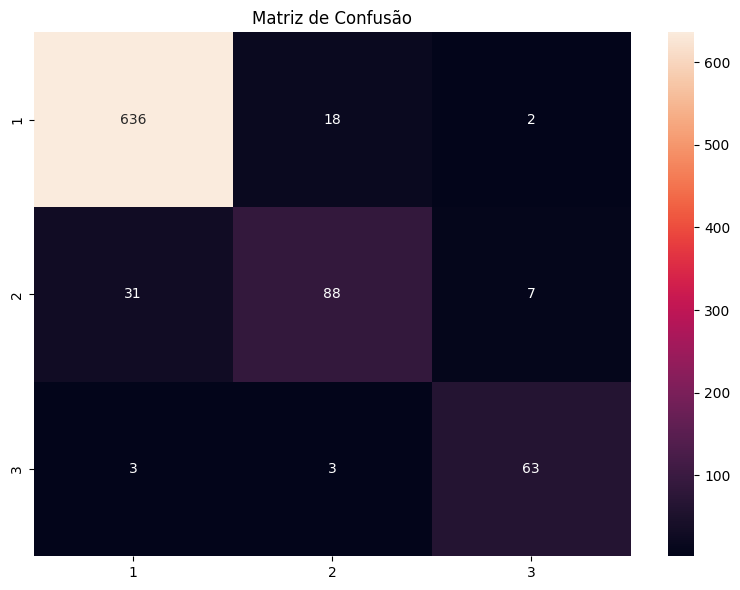

Area sob a curva ROC por classe:


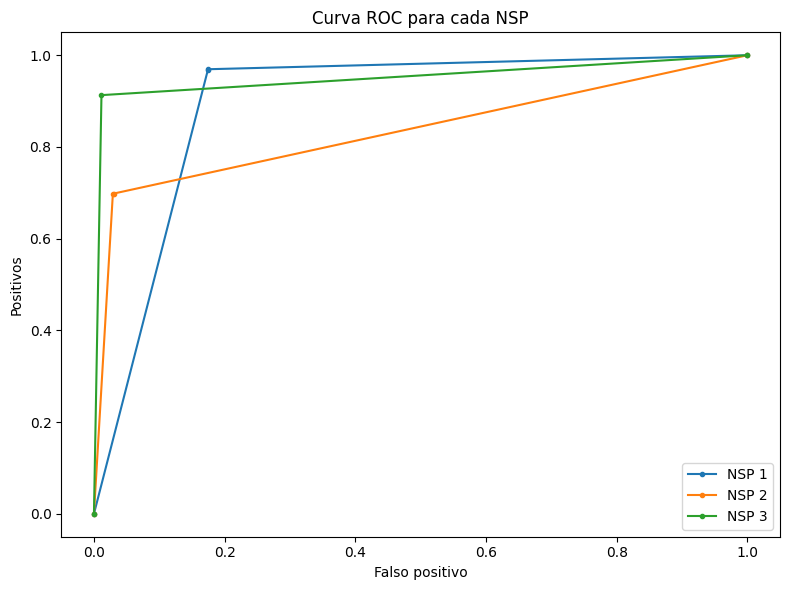

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Melhor Fbeta no conjunto de treinamento: 0.9225132259597263
F1 no conjunto de teste: 0.9275080467438174
ACURACIA no conjunto de teste: 0.9283196239717979
Fbeta no conjunto de teste: 0.9279607949188656
Área sob a curva ROC no conjunto de teste: 0.9029466176780754
Matriz de confusão:


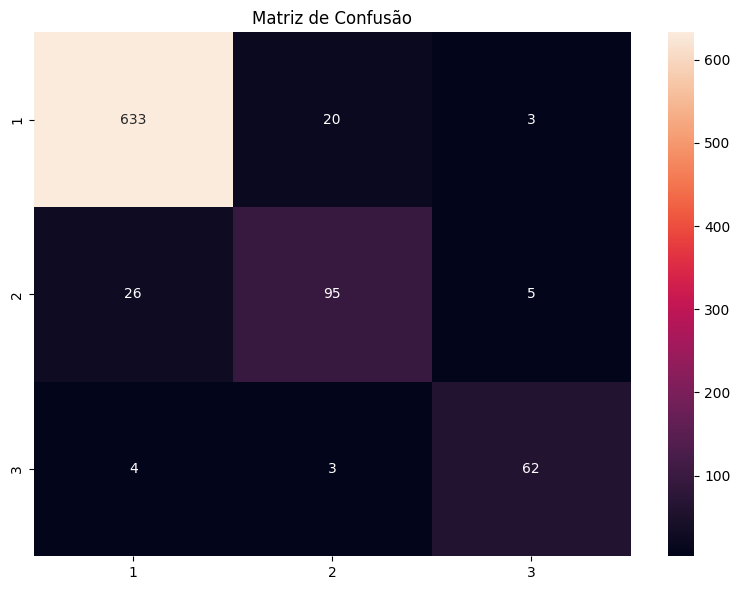

Area sob a curva ROC por classe:


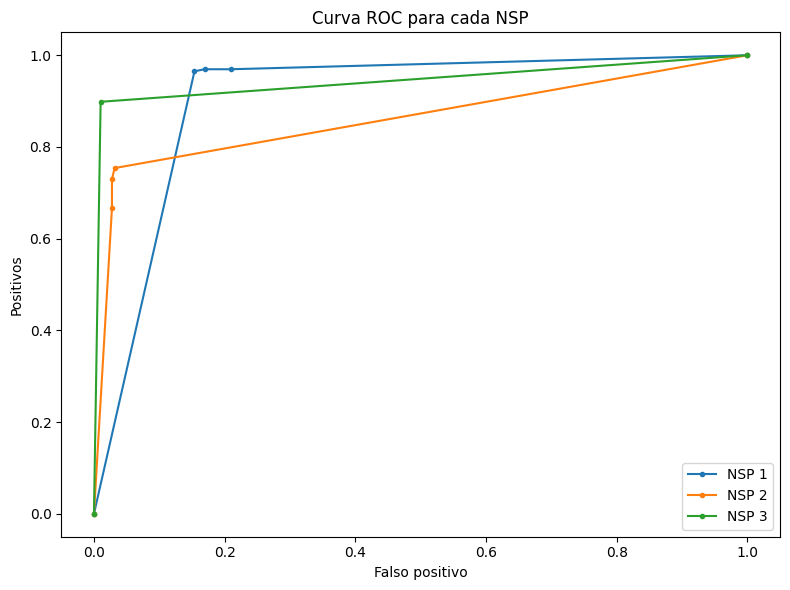

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Melhor F1 no conjunto de treinamento: 0.9245453715896191
F1 no conjunto de teste: 0.9291524277027682
ACURACIA no conjunto de teste: 0.9306698002350177
Fbeta no conjunto de teste: 0.9299578142828392
Área sob a curva ROC no conjunto de teste: 0.899679911175634
Matriz de confusão:


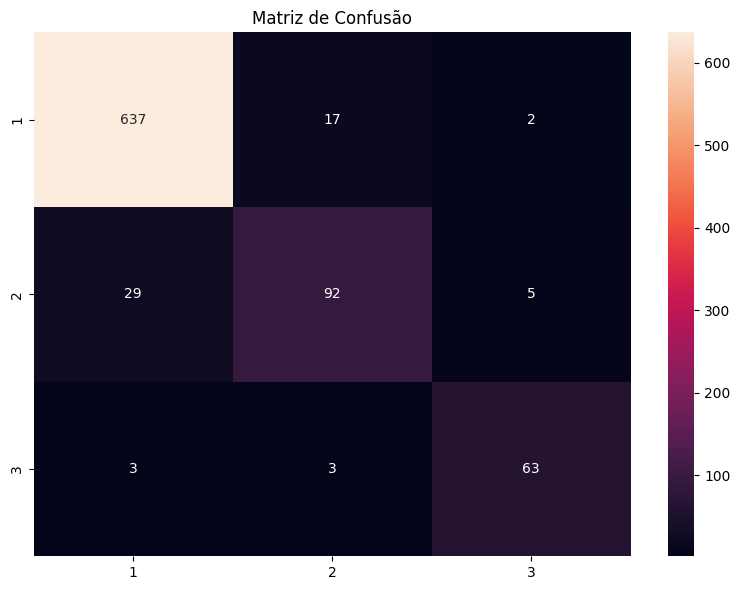

Area sob a curva ROC por classe:


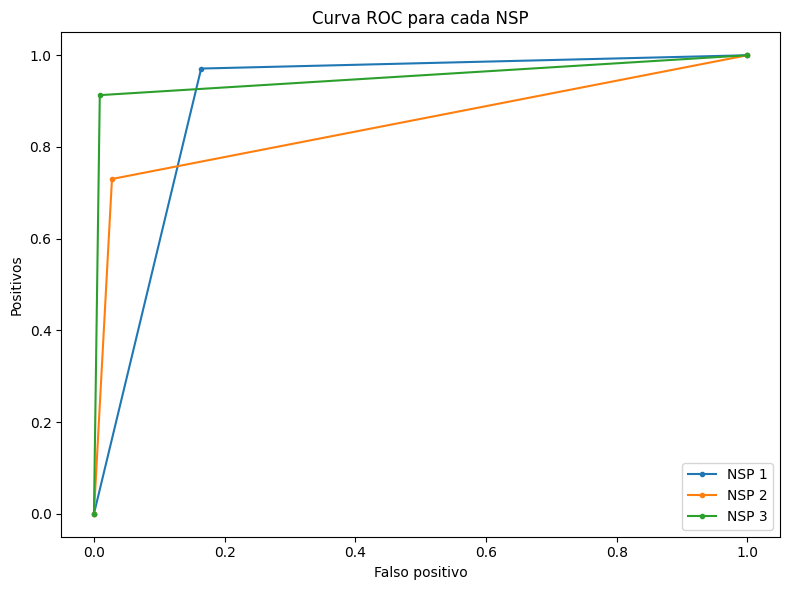

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Melhor ACURACIA no conjunto de treinamento: 0.9271222933070866
F1 no conjunto de teste: 0.9291526972748891
ACURACIA no conjunto de teste: 0.9306698002350177
Fbeta no conjunto de teste: 0.9299398428685659
Área sob a curva ROC no conjunto de teste: 0.9026536487167937
Matriz de confusão:


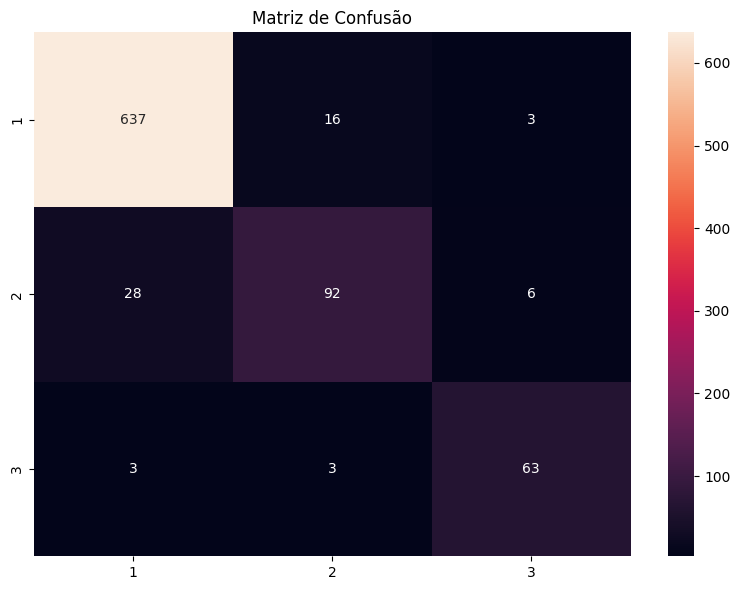

Area sob a curva ROC por classe:


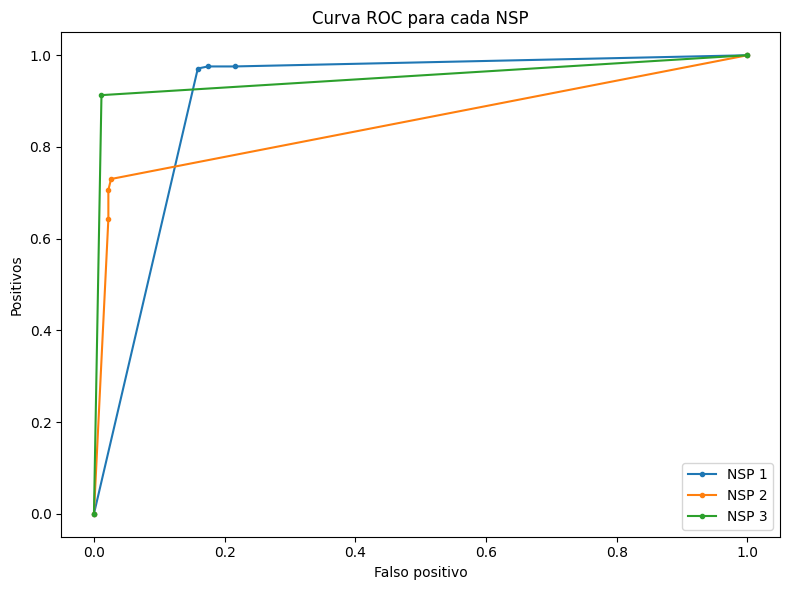

2024/08/11 13:52:47 INFO mlflow.tracking.fluent: Experiment with name 'MLP' does not exist. Creating a new experiment.


=== Treinando MLP ===
Fitting 10 folds for each of 32 candidates, totalling 320 fits
Melhor ROC_AUC no conjunto de treinamento: 0.9440931289943203
F1 no conjunto de teste: 0.8848561129537141
ACURACIA no conjunto de teste: 0.8883666274970623
Fbeta no conjunto de teste: 0.8867696033908569
Área sob a curva ROC no conjunto de teste: 0.9313961112610638
Matriz de confusão:


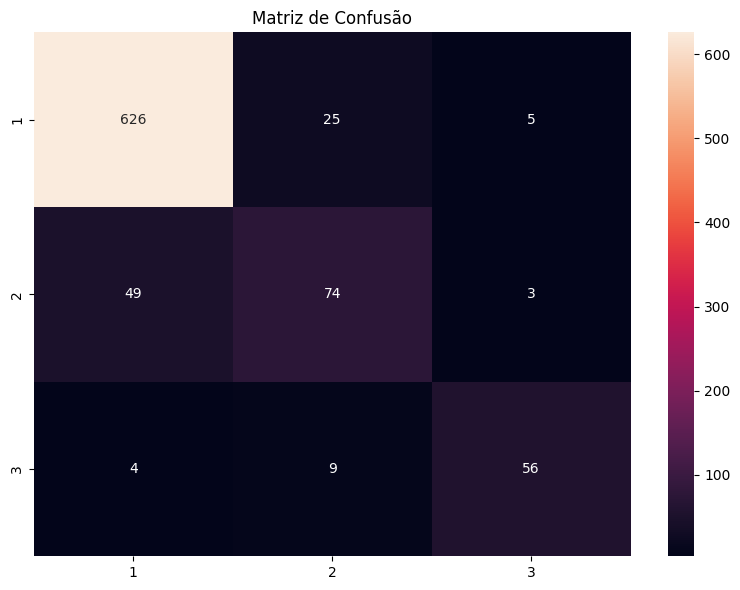

Area sob a curva ROC por classe:


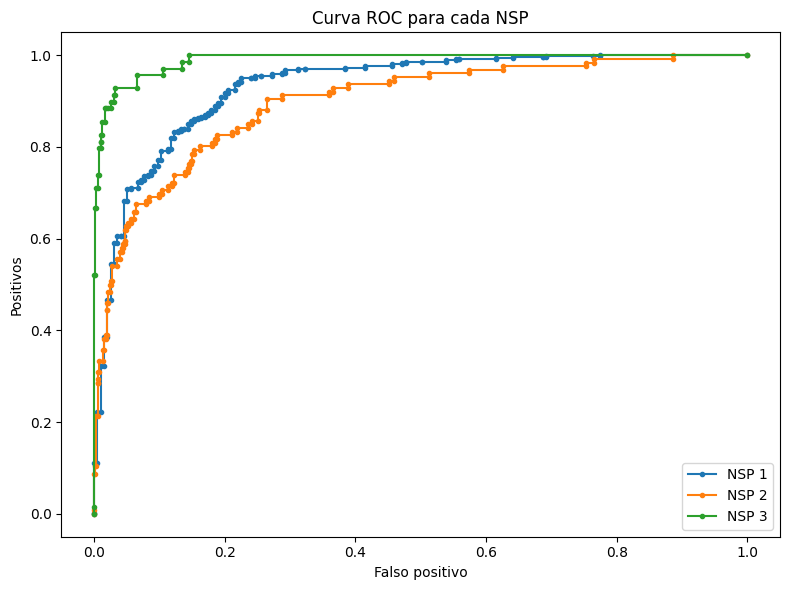

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Melhor Fbeta no conjunto de treinamento: 0.8885443339987672
F1 no conjunto de teste: 0.866472129623766
ACURACIA no conjunto de teste: 0.8754406580493537
Fbeta no conjunto de teste: 0.8711433318988981
Área sob a curva ROC no conjunto de teste: 0.9229175079128874
Matriz de confusão:


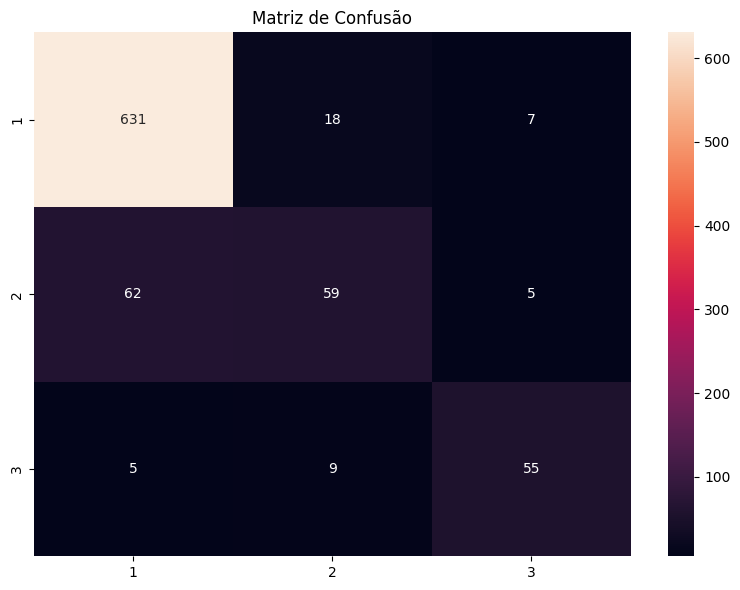

Area sob a curva ROC por classe:


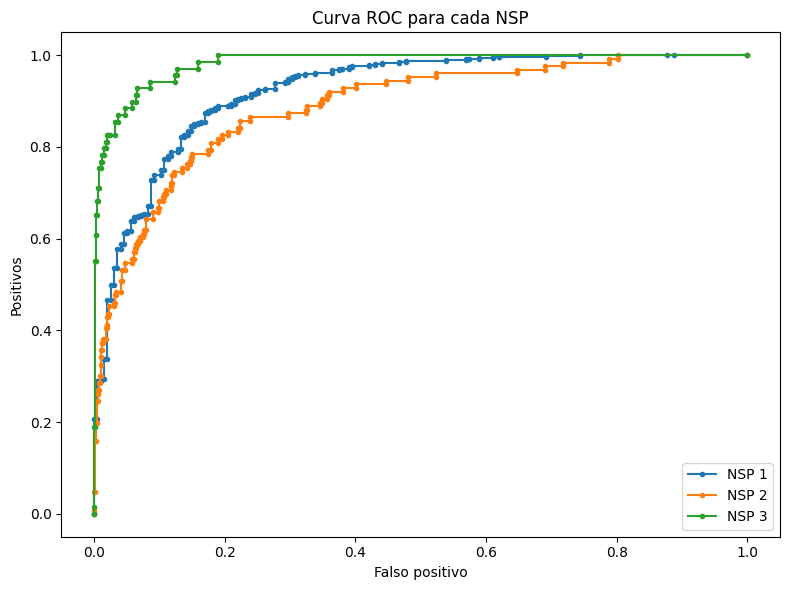

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Melhor F1 no conjunto de treinamento: 0.8886541789669767
F1 no conjunto de teste: 0.8842468822539855
ACURACIA no conjunto de teste: 0.8907168037602821
Fbeta no conjunto de teste: 0.8875513325641203
Área sob a curva ROC no conjunto de teste: 0.9340352701179705
Matriz de confusão:


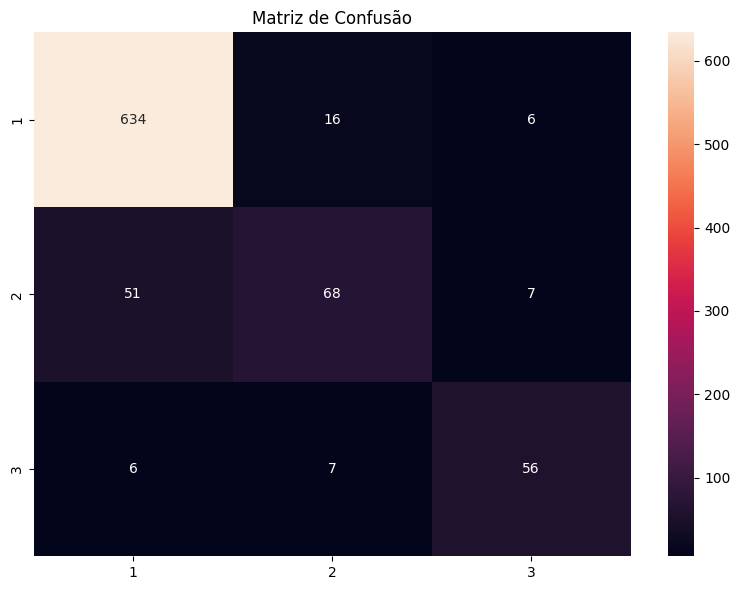

Area sob a curva ROC por classe:


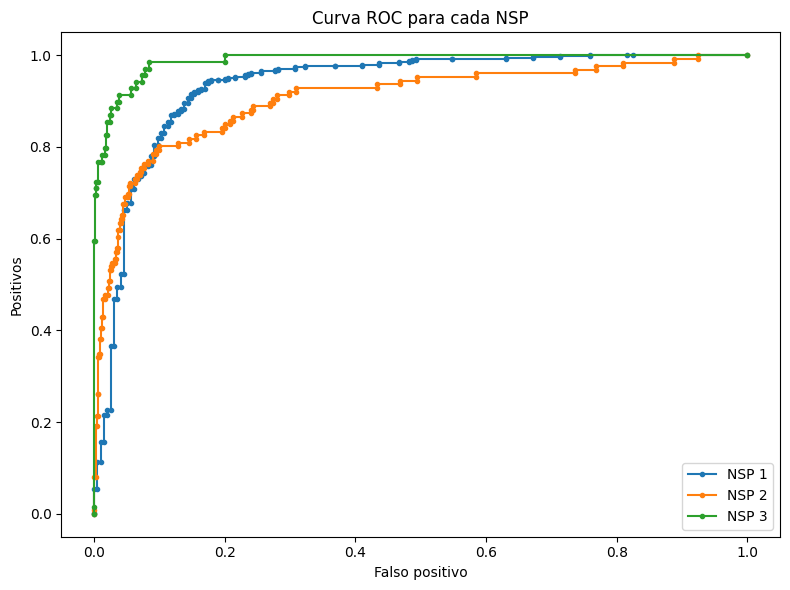

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Melhor ACURACIA no conjunto de treinamento: 0.8901943897637794
F1 no conjunto de teste: 0.8706715890390166
ACURACIA no conjunto de teste: 0.8871915393654524
Fbeta no conjunto de teste: 0.8781593987473798
Área sob a curva ROC no conjunto de teste: 0.943834334726868
Matriz de confusão:


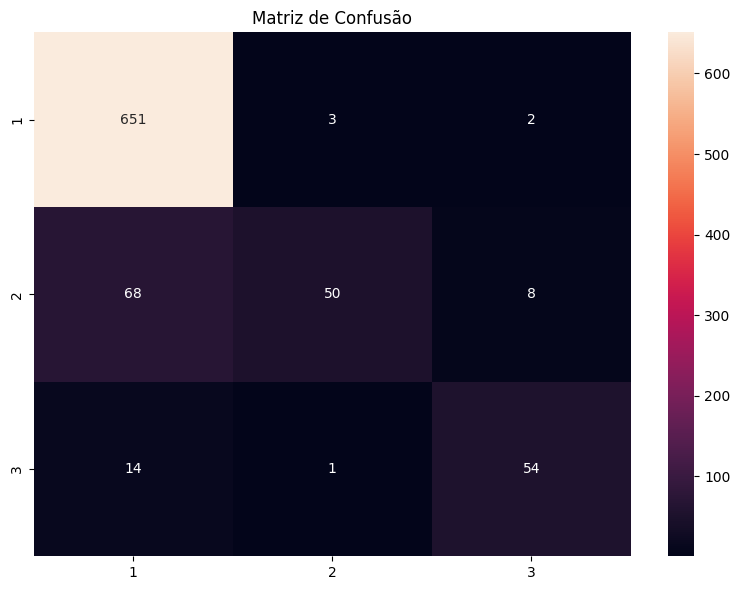

Area sob a curva ROC por classe:


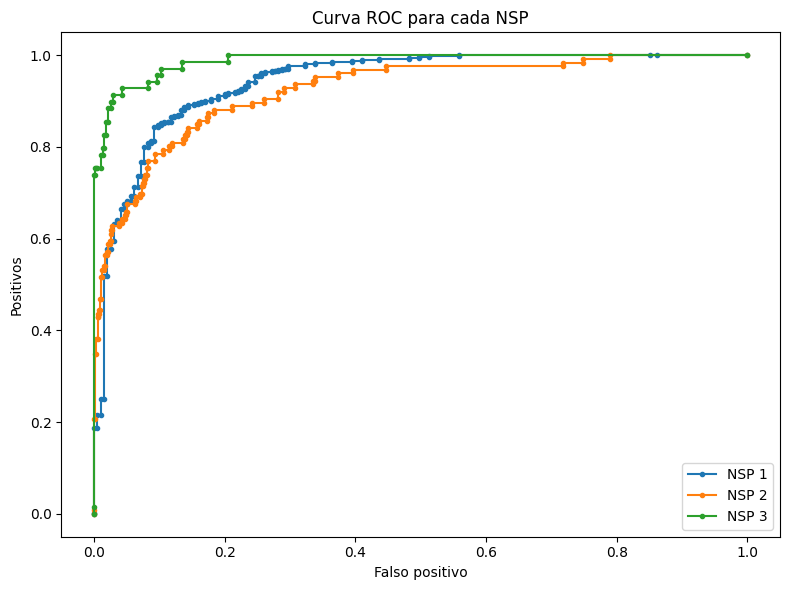

2024/08/11 14:01:56 INFO mlflow.tracking.fluent: Experiment with name 'Naive Bayes' does not exist. Creating a new experiment.


=== Treinando NaiveBayes ===
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Melhor ROC_AUC no conjunto de treinamento: 0.9028773372374819
F1 no conjunto de teste: 0.8304369834838031
ACURACIA no conjunto de teste: 0.8143360752056404
Fbeta no conjunto de teste: 0.8171613855805938
Área sob a curva ROC no conjunto de teste: 0.9182179632145314
Matriz de confusão:


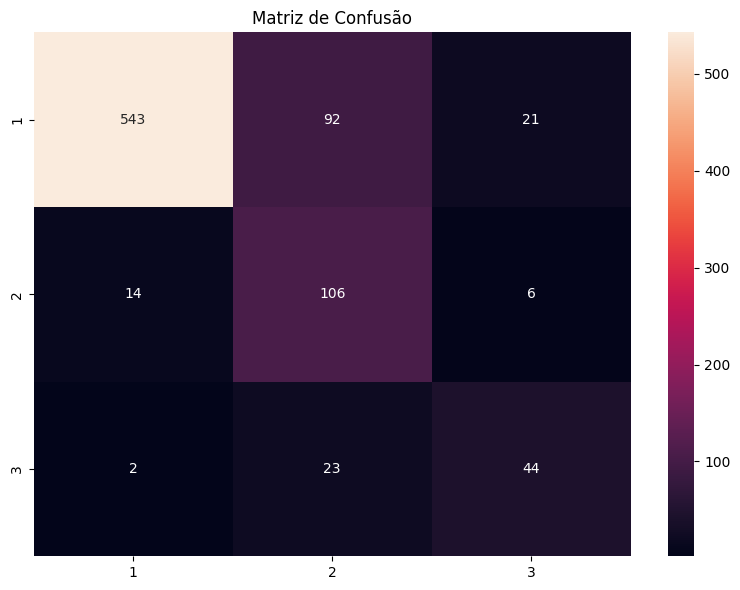

Area sob a curva ROC por classe:


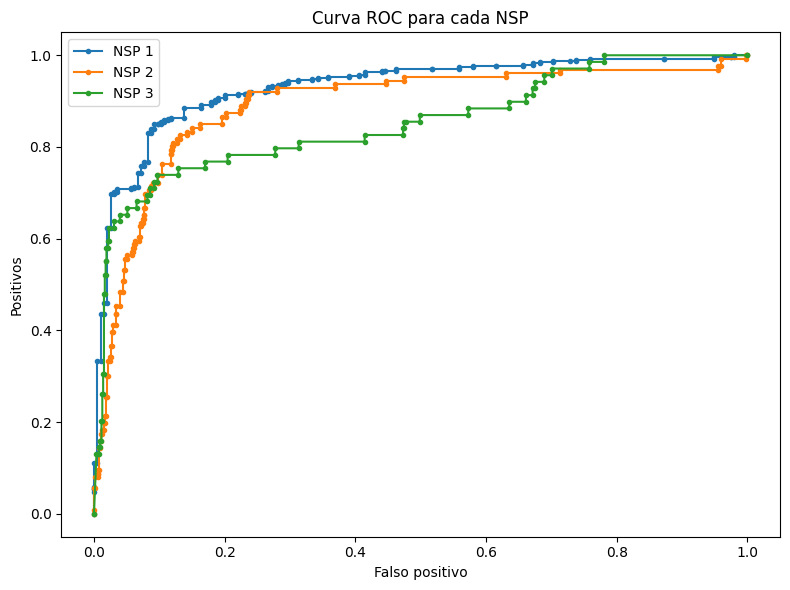

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Melhor Fbeta no conjunto de treinamento: 0.809438397779066
F1 no conjunto de teste: 0.8304369834838031
ACURACIA no conjunto de teste: 0.8143360752056404
Fbeta no conjunto de teste: 0.8171613855805938
Área sob a curva ROC no conjunto de teste: 0.9182179632145314
Matriz de confusão:


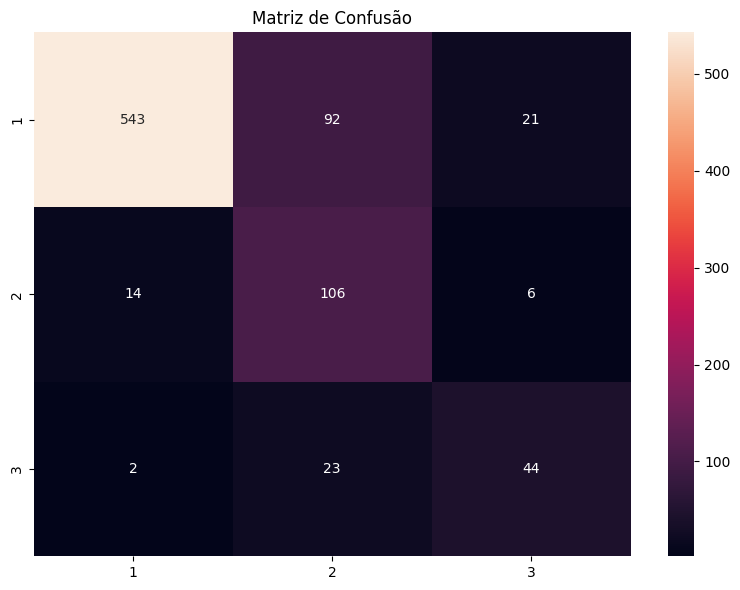

Area sob a curva ROC por classe:


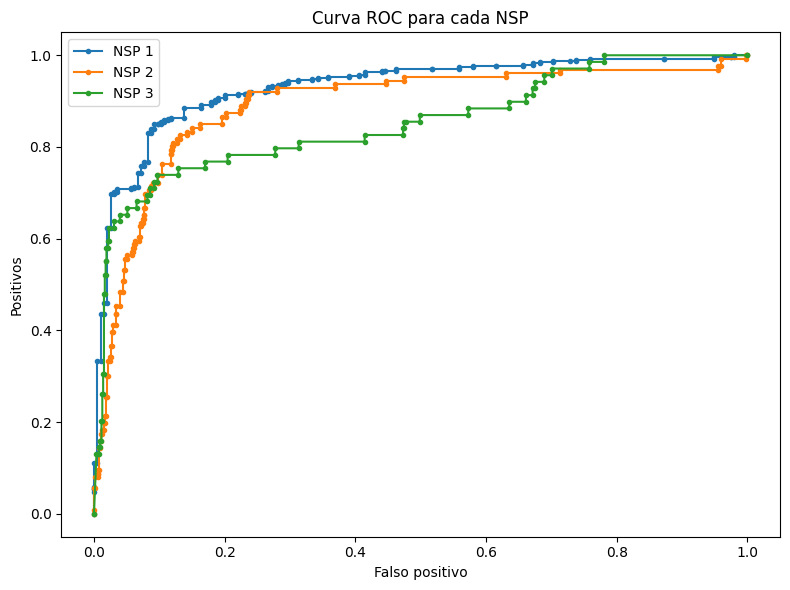

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Melhor F1 no conjunto de treinamento: 0.8247277093941785
F1 no conjunto de teste: 0.8304369834838031
ACURACIA no conjunto de teste: 0.8143360752056404
Fbeta no conjunto de teste: 0.8171613855805938
Área sob a curva ROC no conjunto de teste: 0.9182179632145314
Matriz de confusão:


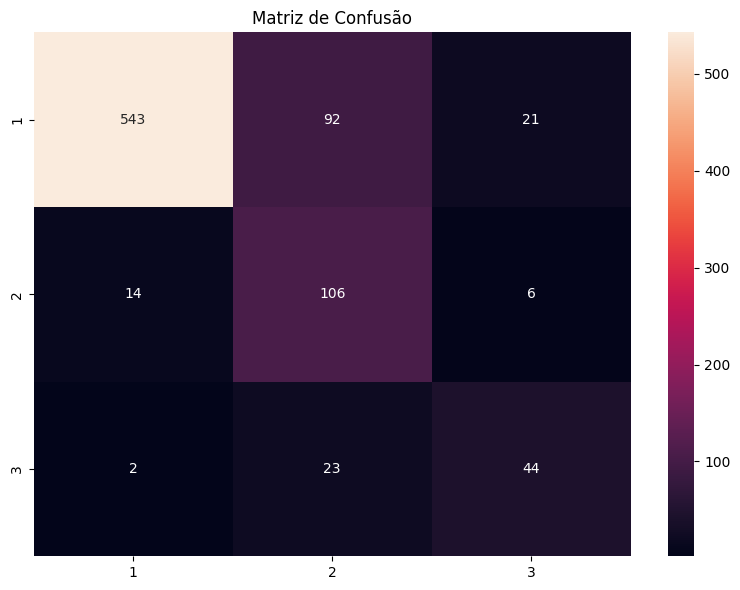

Area sob a curva ROC por classe:


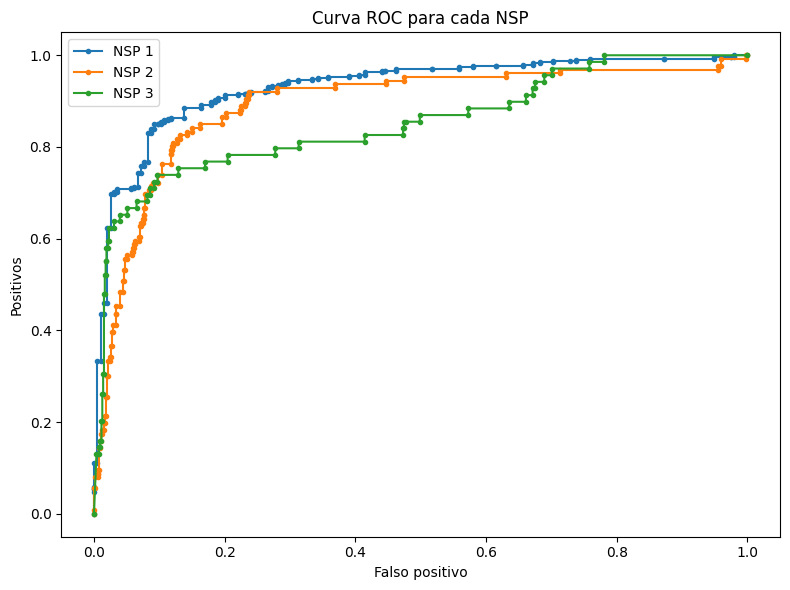

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Melhor ACURACIA no conjunto de treinamento: 0.8070558562992126
F1 no conjunto de teste: 0.8304369834838031
ACURACIA no conjunto de teste: 0.8143360752056404
Fbeta no conjunto de teste: 0.8171613855805938
Área sob a curva ROC no conjunto de teste: 0.9182179632145314
Matriz de confusão:


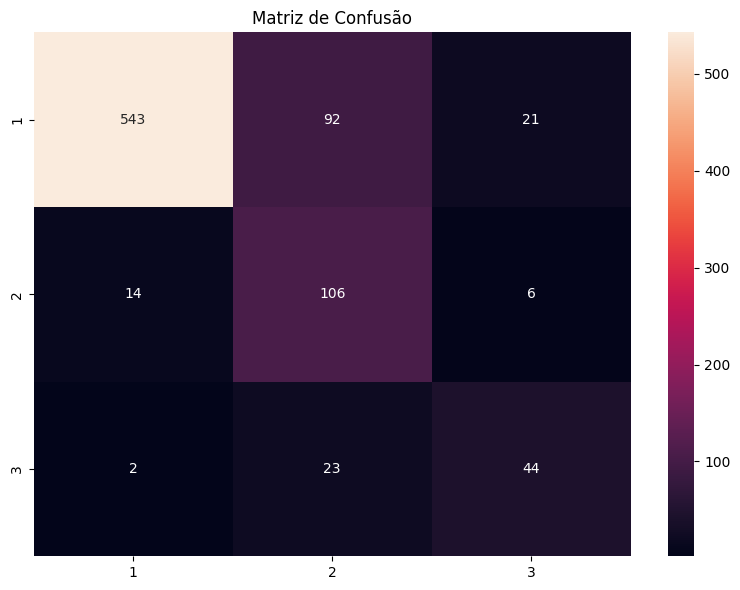

Area sob a curva ROC por classe:


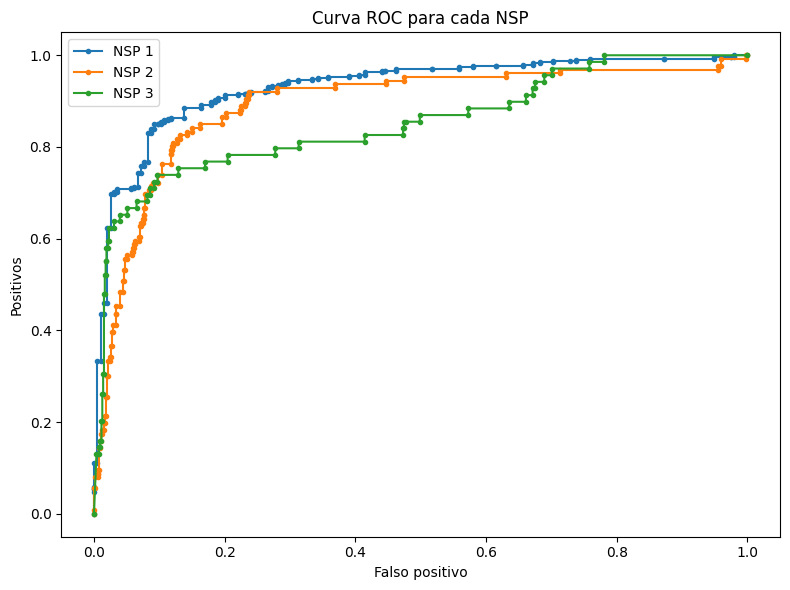

In [101]:
from sklearn.model_selection import GridSearchCV

import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

for clf_name, clf_info in classifiers.items():
    # experimento MLflow
    mlflow.set_experiment(experiment_mapping[clf_name])
    
    print(f"=== Treinando {clf_name} ===")
    
    for score_name, score_metric in scores.items():
        with mlflow.start_run(run_name=f"{clf_name}_{score_name}"):
            grid_search = GridSearchCV(
                estimator=clf_info['model'],
                param_grid=clf_info['param_grid'],
                cv=10,
                n_jobs=-1,
                verbose=1,
                scoring=score_metric
            )
            
            grid_search.fit(X_train, y_train)
            
            # registra parametros
            mlflow.log_params(grid_search.best_params_)
            
            # registra métricas do treinamento
            mlflow.log_metric(f"best_train_{score_name}", grid_search.best_score_)
            print(f"Melhor {score_name} no conjunto de treinamento: {grid_search.best_score_}")
            
            # avaliação no conjunto de testes
            test_metrics = evaluate_best_model(grid_search, X_test, y_test)
            for metric_name, metric_value in test_metrics.items():
                mlflow.log_metric(f"test_{metric_name}", metric_value)
            
            signature = infer_signature(X_train, grid_search.predict(X_train))
            mlflow.sklearn.log_model(grid_search.best_estimator_, f"{clf_name}_model", signature=signature)
            
            # Optional: Log artifacts, e.g., plots, if any
            # mlflow.log_artifact("path_to_artifact")
            
            mlflow.end_run()


### Recuperando dados para análise

In [103]:
import mlflow
from tabulate import tabulate

client = mlflow.tracking.MlflowClient()

# Cabeçalhos da tabela
headers = ["Modelo", "Parâmetros", "Métrica no treinamento", "Acurácia", "F1", "Fbeta", "Área ROC"]

experiments = sorted(client.search_experiments(), key=lambda exp: exp.creation_time, reverse=True)[:4]
print(experiments)

for score_name, score_metric in scores.items():
    table_data = []
    print(f"======== Considerando {score_name} como métrica de avaliação do cross fold: ========")

    for experiment in experiments:
        table_row = []
        experiment_id = experiment.experiment_id
        experiment_name = experiment.name
        table_row = [experiment_name] 
        params_cell = []
        
        # Procura por runs dentro do experimento
        runs = client.search_runs(experiment_ids=experiment_id)
        for run in runs:
            run_name = run.data.tags.get("mlflow.runName", "Sem nome")
            if score_name in run_name:

                params = client.get_run(run.info.run_id).data.params
                params_cell = ", ".join([f"{param_name}: {param_value}" for param_name, param_value in params.items()])
                table_row.append(params_cell)

                # Adiciona as métricas
                metrics = client.get_run(run.info.run_id).data.metrics
                for metric_name, metric_value in metrics.items():
                    table_row.append(metric_value)

                table_data.append(table_row)

    # Imprime a tabela com formatação
    print(tabulate(table_data, headers, tablefmt="fancy_grid"))


[<Experiment: artifact_location='file:///c:/Users/talita.mota/Documents/aprendizagem-maquina-i/mlruns/418855198438009620', creation_time=1723395716157, experiment_id='418855198438009620', last_update_time=1723395716157, lifecycle_stage='active', name='Naive Bayes', tags={}>, <Experiment: artifact_location='file:///c:/Users/talita.mota/Documents/aprendizagem-maquina-i/mlruns/376077375811744551', creation_time=1723395167929, experiment_id='376077375811744551', last_update_time=1723395167929, lifecycle_stage='active', name='MLP', tags={}>, <Experiment: artifact_location='file:///c:/Users/talita.mota/Documents/aprendizagem-maquina-i/mlruns/821527060771966608', creation_time=1723395146435, experiment_id='821527060771966608', last_update_time=1723395146435, lifecycle_stage='active', name='Decision Tree', tags={}>, <Experiment: artifact_location='file:///c:/Users/talita.mota/Documents/aprendizagem-maquina-i/mlruns/312893383469795922', creation_time=1723395121754, experiment_id='31289338346979